In [82]:
import warnings
warnings.filterwarnings('ignore')

try:
  import akshare as ak
  import pandas as pd
  import quantstats as qs
except ImportError:
  !pip install akshare
  !pip install pandas
  !pip install quantstats
  import akshare as ak
  import pandas as pd
  import quantstats as qs

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from matplotlib.dates import AutoDateLocator
from itertools import combinations
print("安装包导入完毕")

class ETFStrategy:
  def __init__(self, etf_symbols, stop_params, window_size=21, threshold=1.5):
    self.etf_symbols = etf_symbols
    self.stop_params = stop_params
    self.window_size = window_size
    self.threshold = threshold
    self.data = self.init_data()

  def init_data(self):
    etf_data = {}
    for symbol in self.etf_symbols:
        etf_df = ak.fund_etf_hist_em(symbol=symbol, period="daily", adjust='hfq')[['日期', '收盘']] \
                .rename(columns={'日期': 'date', '收盘': symbol}).set_index('date')
        etf_data[symbol] = etf_df

    data = pd.concat(list(etf_data.values()), axis=1).dropna()
    data.index = pd.to_datetime(data.index)

    for symbol in self.etf_symbols:
        column_name = f"{symbol}"
        data[f"{column_name}_day_return"] = data[column_name].rolling(2).apply(lambda x: x[-1]/x[0]-1)
        data[f"{column_name}_return"] = data[column_name].rolling(window=self.window_size).apply(lambda x: x[-1]/x[0]-1)
        data[f"{column_name}_ma"] = data[column_name].rolling(window=self.window_size).mean()

    data = data.dropna()

    return data

  def inert(self):
    signal_list = []
    count = 0
    prev_signal = None
    for i, (index, row) in enumerate(self.data.iterrows()):
        tmp_signal = row[[f"{symbol}_return" for symbol in self.etf_symbols]].idxmax().split('_')[0]
        if i == 0:
            prev_signal = tmp_signal

        if tmp_signal != prev_signal:
            prev_ret = row[f"{prev_signal}_return"]
            tmp_ret = row[f"{tmp_signal}_return"]
            if prev_ret != 0:
                if np.abs(1-tmp_ret/prev_ret) > self.threshold:
                    prev_signal = tmp_signal
                    count += 1

        signal_list.append(prev_signal)

    return count, signal_list

  def stop(self, input_list):
    window_size, gain_threshold, loss_threshold, stop_period = self.stop_params
    for i in range(len(input_list)):
        if i >= window_size:
            window_sum = sum(input_list[i+1-window_size:i+1])
            if window_sum > gain_threshold:
                input_list.loc[input_list.index[i+1:i+1+stop_period]] = 0
            elif window_sum < loss_threshold:
                input_list.loc[input_list.index[i+1:i+1+stop_period]] = 0
    return input_list

  def pnl_curve(self, show=True):
    count, self.data['signal'] = self.inert()

    self.data['signal'] = self.data['signal'].shift(1)
    self.data = self.data.dropna()

    self.data["signal_return"] = (np.cumprod(self.data.apply(lambda row: row[f'{row["signal"]}_day_return'], axis=1) + 1) * 100)
    self.data = self.data.dropna()

    self.data['signal_day_return'] = self.data.apply(lambda row: row[f'{row["signal"]}_day_return'], axis=1)
    signal_day_return = self.data['signal_day_return'].copy()

    self.data['stop_gain_day_return'] = self.stop(signal_day_return)

    self.data["signal_return"] = np.cumprod(self.data['stop_gain_day_return'] + 1) * 100
    self.data['former_return'] = np.cumprod(self.data['signal_day_return'] + 1) * 100

    for symbol in self.etf_symbols:
        column_name = f"{symbol}_return"
        self.data[column_name] = 100 * self.data[f"{symbol}"] / self.data[f"{symbol}"].values[0]

    if show:
        self.plot_pnl_curve()

    return self.data

  def plot_pnl_curve(self):
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.set_xlabel('Time')
    ax.set_ylabel('Return')

    for symbol in self.etf_symbols:
      ax.plot(self.data[f"{symbol}_return"].index, self.data[f"{symbol}_return"].values)
    ax.plot(self.data["signal_return"].index, self.data["signal_return"].values)
    ax.legend([*self.etf_symbols, "signal_return"])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(500))

    colors = ["blue", "orange", "green", "red"]
    color_map = {}
    for i, symbol in enumerate(self.etf_symbols):
        color_map[symbol] = colors[i]

    prev_signal = None
    for i, (index, row) in enumerate(self.data.iterrows()):
        current_signal = row['signal']
        if i == 0:
            prev_signal = current_signal
            continue

        color = color_map[current_signal]
        ax.axvspan(self.data.index[i - 1], index, facecolor=color, alpha=0.3)

        if current_signal != prev_signal:
            prev_signal = current_signal

    plt.show()

  def today(self):
    empty = self.is_empty()
    signal = self.data.iloc[-1]["signal"]
    if not empty:
        return signal
    else:
        return 0

  def is_empty(self):
    no_stop_return, stop_return = self.data.iloc[-1][["signal_day_return", "stop_gain_day_return"]]
    if no_stop_return != stop_return and stop_return == 0:
        return True
    else:
        return False

class Main:
  def __init__(self):
    # Define ETF symbols
    self.etf_symbols_1 = ["518880", "513100"]
    self.etf_symbols_2 = ['159915', '512890']
    self.etf_symbols_3 = ['512040', '513000', '159985']
    self.stop_params = (10, 0.1, -0.15, 2)

    # Strategy instantiation
    self.strategy1 = ETFStrategy(self.etf_symbols_1, self.stop_params, window_size=21, threshold=1.3)
    self.strategy2 = ETFStrategy(self.etf_symbols_2, (10, 0.1, -0.15, 1), window_size=14, threshold=1.75)
    self.strategy3 = ETFStrategy(self.etf_symbols_3, self.stop_params, window_size=20, threshold=1.5)

    # Get full data
    self.first_data = self.strategy1.pnl_curve(show=False)
    self.second_data = self.strategy2.pnl_curve(show=False)
    self.third_data = self.strategy3.pnl_curve(show=False)

    # Get holdings
    self.holdings = [self.strategy1.today(), self.strategy2.today(), self.strategy3.today()]

  # Calculate cumulative return
  def cumulative_return(self):
    ret_type = 'stop_gain_day_return'
    ports = ["first", "second", "third"]
    df = pd.concat([self.first_data[ret_type], self.second_data[ret_type], self.third_data[ret_type]], axis=1)
    df.columns = ports
    df[[f"{port}_period" for port in ports]] = df[[f"{port}" for port in ports]].rolling(window=21).apply(lambda x: (1+x).prod()-1, raw=True)
    df.dropna(inplace=True)
    df[[f'{port}_weight' for port in ports]] = df[[f'{port}_period' for port in ports]].apply(
        lambda row: pd.Series(row).rank(method='min').astype(int),
        axis=1
    )/6
    values = df[ports]
    weights = df[[f'{port}_weight' for port in ports]] * [bool(x) for x in self.holdings]
    df["initial"] = values.mean(axis=1)
    df["signal"] = np.sum(values.values * weights.values, axis=1)
    df["initial_return"] = (1 + values.mean(axis=1)).cumprod()
    df["signal_return"] = (1 + df["signal"]).cumprod()
    latest_weights = weights.iloc[-1]
    cum_return = df["signal_return"].iloc[-1]

    return latest_weights, cum_return, df["signal_return"]

  # Get today's position
  def get_position(self):
    weights, cum_return, _ = self.cumulative_return()
    dict = {"513000": "日经", "512040": "价值100", "512890": "红利低波", "159915": "创业板", "159985": "豆粕", "513100": "纳指", "518880": "黄金"}
    result = pd.DataFrame([weights.values, self.holdings]).T
    result.index = [1,2,3]
    result.columns = ["weight", "symbol"]
    result["name"] = [dict[symbol] for symbol in result["symbol"]]
    return result

  # Plot past one month return
  def plot(self, days, dpi=100):
    start = datetime.now().date() - timedelta(days=30)
    end = datetime.now().date()

    # My return
    return_series = main.cumulative_return()[2]
    return_series.index = pd.to_datetime(return_series.index)

    # My competitor's return
    base_return = ak.fund_open_fund_info_em(symbol="000979").set_index("净值日期")["日增长率"]
    base_return.index = pd.to_datetime(base_return.index)
    base_return = (1 + base_return * 0.01).cumprod()

    # Index's return
    idx_return = ak.index_zh_a_hist(symbol="000300", period="daily", start_date=start, end_date=end).set_index("日期")["涨跌幅"]
    idx_return.index = pd.to_datetime(idx_return.index)
    idx_return = (1 + idx_return * 0.01).cumprod()

    # Combine and align
    df = pd.concat([return_series, base_return, idx_return], axis=1)
    df.columns = ["mine", "base", "index"]
    df.dropna(inplace=True)
    df = df[start: end]
    df = (df / df.iloc[0] - 1) * 100

    # Plot graph
    plt.plot(df.index, df["mine"], label="mine")
    plt.plot(df.index, df["base"], label="base")
    plt.plot(df.index, df["index"], label="index")
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=7))
    plt.legend()
    plt.grid()
    plt.show()

main = Main()
print("Main实例创建完毕")

安装包导入完毕
Main实例创建完毕


In [85]:
# Calculate cumulative return
weights, cum_return, _ = main.cumulative_return()
print(f"Cumulative return: {cum_return:.4f}")

# Get today's position
result = main.get_position()
print(result)

Cumulative return: 6.6109
     weight  symbol  name
1  0.333333  513100    纳指
2  0.166667  512890  红利低波
3       0.5  513000    日经


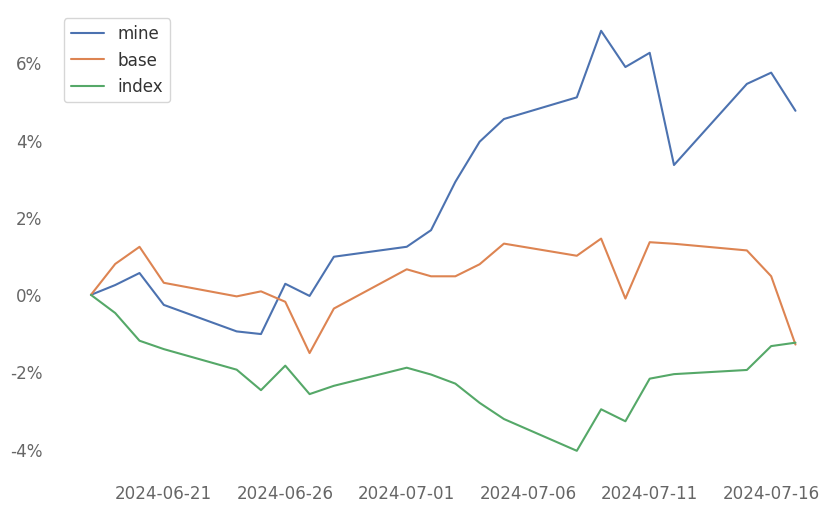

In [83]:
main.plot(days=30)